# Μεταπτυχιακό Μάθημα "Διασφάλιση Ποιότητας"
## Άσκηση ΜΚ-04: "Επικύρωση Μεθόδου"
||||||
-----|-----|-------|------|-------
**Ονοματεπώνυμο:**|**Αλέξανδρος Ρόδης**||**Αριθμός Μητρώου:**|**202218**
**Μεταπτυχιακό Πρόγραμμα:**|**Αναλυτική Χημεία - Διασφάλιση Ποιότητας**


(Τα αποτελέσματα να συμπληρωθούν  στους πίνακες και τα διαγράμματα / εκτυπώσεις να επισυναφθούν).
Για την επικύρωση μεθόδου προσδιορισμού $Hg$ σε ψάρια με την τεχνική φασματομετρίας ατομικής απορρόφησης  - παραγωγής υδριδίων έγιναν  τα παρακάτω πειράματα και πάρθηκαν τα εξής αποτελέσματα.

## Καμπύλη Βαθμονόμησης Οργάνου - Γραμμικότητα

Χρησιμοποιήθηκε το όργανο: Φασματόμετρο Ατομικής Απορρόφησης, Perkin-Elmer 4110 ZL με σύστημα υδριδίων  FIAS – 400 (Flow Injection – Atomic Spectrometer), με αριθμό AAS-02. Παρασκευάσθηκε σειρά προτύπων διαλυμάτων Hg (0 – 20,0 μg/L ή $(^{ng}/_{mL})$ σε αραιό διάλυμα $HNO_3$ και μετρήθηκε εις τριπλούν το ύψος των κορυφών απορρόφησης  $(A_i)$ σε μονάδες απορρόφησης. Πάρθηκαν τα  αποτελέσματα του παρακάτω πίνακα:

In [52]:
from openpyxl import load_workbook
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statistics import mean, stdev
import statsmodels.api as sm
from statsmodels.formula.api import ols
from math import sqrt,log
import scipy.stats as stats
from IPython import display
import pingouin as pg
import warnings
from collections import namedtuple
from typing import Union,Optional

warnings.filterwarnings('ignore')

# Display settings
plt.rcParams['figure.figsize'] = [20,6]
plt.rcParams['figure.dpi'] = 125 # 200 e.g. is really fine, but slower

# Styling 
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [53]:
df1 = pd.read_csv("Άσκηση ΜΚ-04 - Επικύρωση Μεθόδου T-1 Γραμμικότητα.csv", index_col = False)
df1_head = df1.iloc[0]
df1=df1[1:]
df1.columns = df1_head
df1.reset_index(inplace=True)
df1 = df1.rename(columns = {'%Relative Standard Deviation.%RSD': '%Relative Standard Deviation (%RSD)',
                           'Instrument Response-Curve Height (Ai)' : 'Instrument Response - Curve Height (Ai)'
                           })
                            
q_param = namedtuple("QualityParameter", ["experimental","legal_req", "conforms"] )  
f_results = {
    "LOD - Οργάνου (ng/mL)":None,
    "LOQ - Οργάνου (ng/mL)":None,
    "Γραμμικότητα - Συντελεστής Συσχέτησης":None,
    "Επαναληψημότητα %RSDr":None,
    "Ενδιάμεση Πιστότητα %RSDR":None,
    "Ακρίβεια - Πιστοποιημένο Υλικό Αναφοράς":None,
    "Ακρίβεια - Πειράματα Ανάκτησης":None,
    "Όριο Ανίχνευσης (LOD) - Μεθόδου":None,
    "Όριο Ποσοτικοποίησης (LOD) - Μεθόδου":None,
    "Πιστότητα - Δείκτης HORRAT":None,
}

inpt = Union[str,float,None]

def set_legal_param(res:str,exp:inpt,leg:inpt):
    f_results[res] = q_param(float(exp),float(leg),float(exp)<=float(leg))

In [3]:
# Data type cleanup 
df1.columns
types = {
       'Sample Number' : 'int16', 
       'Concentration [Hg] (ug/g)':'float32', 
       'Instrument Response - Curve Height (Ai)':'float32', 
       'Average':'float64',
       'Standard Deviation (SD)':'float64', 
       '%Relative Standard Deviation (%RSD)':'float64'
        }
df1 = df1.astype(types)

Βασικές στατιστικές παράμετροι είναι ο μέσος όρος σημάτων, η τυπική απόκλιση (δείγματος) και τη σχετική τυπική απόκλιση:

|||
----|----
Μέσος Όρος|$\overline{x} = \dfrac{\sum_{i=0}^{N}{x_i}}{N}$
Τυπική Απόκλιση|$s = \sqrt{ \dfrac{\sum_{i=1}^N{(x_i-\overline{x})^2}}{N-1} }$
Σχετική Τυπική Απόκλιση|$\%RSD = \dfrac s{|\overline{x}|}*100\%$

In [4]:
for i, col in df1.iterrows():
                 if i%3==0 or i==0:
                     m = mean( [df1.loc[i,'Instrument Response - Curve Height (Ai)'],df1.loc[i+1,'Instrument Response - Curve Height (Ai)'],df1.loc[i+2,'Instrument Response - Curve Height (Ai)']]  )
                     sd = df1.loc[i:i+2,'Instrument Response - Curve Height (Ai)'].std()
                     df1.loc[i+1,'Average'] = m
                     df1.loc[i+1, 'Standard Deviation (SD)'] = sd
                     df1.loc[i+1, '%Relative Standard Deviation (%RSD)'] = sd/m*100

In [5]:
df1["%Relative Standard Deviation (%RSD)"] = df1["%Relative Standard Deviation (%RSD)"].round(2)
# df1.replace(np.nan, '', regex=True)
df1

,index,Sample Number,Concentration [Hg] (ug/g),Observation,Instrument Response - Curve Height (Ai),Average,Standard Deviation (SD),%Relative Standard Deviation (%RSD)
0,1,1,0.0,White,0.0006,NaN,NaN,NaN
1,2,1,0.0,White,0.0007,0.0007,0.0001,14.29
2,3,1,0.0,White,0.0008,NaN,NaN,NaN
3,4,2,0.5,Curve,0.0074,NaN,NaN,NaN
4,5,2,0.5,Curve,0.0075,0.0075,0.0001,1.33
5,6,2,0.5,Curve,0.0076,NaN,NaN,NaN
6,7,3,2.5,Curve,0.0374,NaN,NaN,NaN
7,8,3,2.5,Curve,0.0373,0.0374,0.0001,0.27
8,9,3,2.5,Curve,0.0375,NaN,NaN,NaN
9,10,4,5.0,Curve,0.0754,NaN,NaN,NaN


Η τιμή του λευκού δεν είναι ακριβώς μηδενική, επομένως η μέση τιμή των τριών μετρήσεων θα πρέπει να αφαιρεθεί από τις υπόλοιπες.

In [6]:
blanc = df1[df1['Observation'] == 'White'][df1['Average'].notna()]['Average']

for i,col in df1.iterrows():
    if i%3 == 0:
        df1.loc[i+1,"Average"] = df1.loc[i+1,"Average"] - float(blanc)
df1 = df1[df1['Concentration [Hg] (ug/g)'] != 0.0]
df1

,index,Sample Number,Concentration [Hg] (ug/g),Observation,Instrument Response - Curve Height (Ai),Average,Standard Deviation (SD),%Relative Standard Deviation (%RSD)
3,4,2,0.5,Curve,0.0074,NaN,NaN,NaN
4,5,2,0.5,Curve,0.0075,0.0068,0.0001,1.33
5,6,2,0.5,Curve,0.0076,NaN,NaN,NaN
6,7,3,2.5,Curve,0.0374,NaN,NaN,NaN
7,8,3,2.5,Curve,0.0373,0.0367,0.0001,0.27
8,9,3,2.5,Curve,0.0375,NaN,NaN,NaN
9,10,4,5.0,Curve,0.0754,NaN,NaN,NaN
10,11,4,5.0,Curve,0.0755,0.0747,0.0001,0.13
11,12,4,5.0,Curve,0.0753,NaN,NaN,NaN
12,13,5,7.5,Curve,0.1159,NaN,NaN,NaN


### Ετεροσκεδαστικότητα

Το φαινόμενο κατά το οποίο η τυπική απόκλιση **δεν** παραμένει περίππου σταθερή σε όλη τη δυναμική περιοχή ονομάζεται **ετεροσκεδαστικότηα** (ενό το αντίθετο **όμοσκεδαστικότητα**). Μια ιδιαίτερη περίπτωση αυτού του φαινομένου είναι όταν η μεν τυπική απόκλιση δεν είναι περίππου σταθερή, αλλά η *σχετική* τυπική απόκλιση είναι. Αυτό σημαίνει ότι η τυπική απόκλιση αυξάνεται με τη συγκέντρωση. Η ετεροσκεδαστικότητα είναι ανεπιθύμητη γενικά, γιατί τα περισσότερα μοντέλα που χρησιμοποιούμε υποθέτουν ομοσκεδαστικότητα και γιατί οι περισσότερο απομακρυσμένες τιμές έχουν πολύ μεγαλύτερη επίδραση σε μια εξίσωση παλινδρόμησης. 

Μπορούμε να ελένξουμε αν υπάρχει ετεροσκεδαστικότητα με τον εξής τρόπο. Αρχικά κάνουμε μια οπτική παρατήρηση στα διαγράμματα $S=S(C)$, $\frac SC =\frac SC(C)$ (απόκρισης) καθώς και στο διάγραμμα των υπολοίπων (*residuals*) δηλαδή το $(x_i-\overline{x})=f(C)$. Σε αυτά τα διαγράμματα αναμένουμε γραμμική σχέση (περίππου) ενώ εάν υπάρχει κάποια εμφανή τάση (*trend*) τότε έχουμε ετεροσκεδαστικότητα. Σημειώνουμε οτι στα ίδια διαγράμματα φαίνεται και η πιθανή παρουσία *έκτροπων τιμών (outliers)*. Το διάγραμμα λόγο απόκρισης προς συγκέντρωση συναρτήση της συγκέντρωσης πρέπει να είναι ευθεία γραμμή.

Πέραν από την καθαρά οπτική παρατήρηση, εφαρμώζουμε και το ακόλουθο αριθμητικό κριτήριο
> **Κριτήριο Ετεροσκεδαστικότητας:** \
> Αν ισχύει ότι:\
> $\dfrac {\max{s_i}}{\min{s_i}}\notin [0.8,1.2]\iff$
> ετεροσκεδαστικότητα

Η ετεροσκεδαστικότητα μπορεί να αντιμετοπιστεί με *ζυγισμένη (weighted)* παλινδρόμηση, όπου η πλέον η εξίσωση γίνεται από $S=f(C)$, $S=f(\frac1C)$ ή $\frac 1S=f(C)$ άλλη.

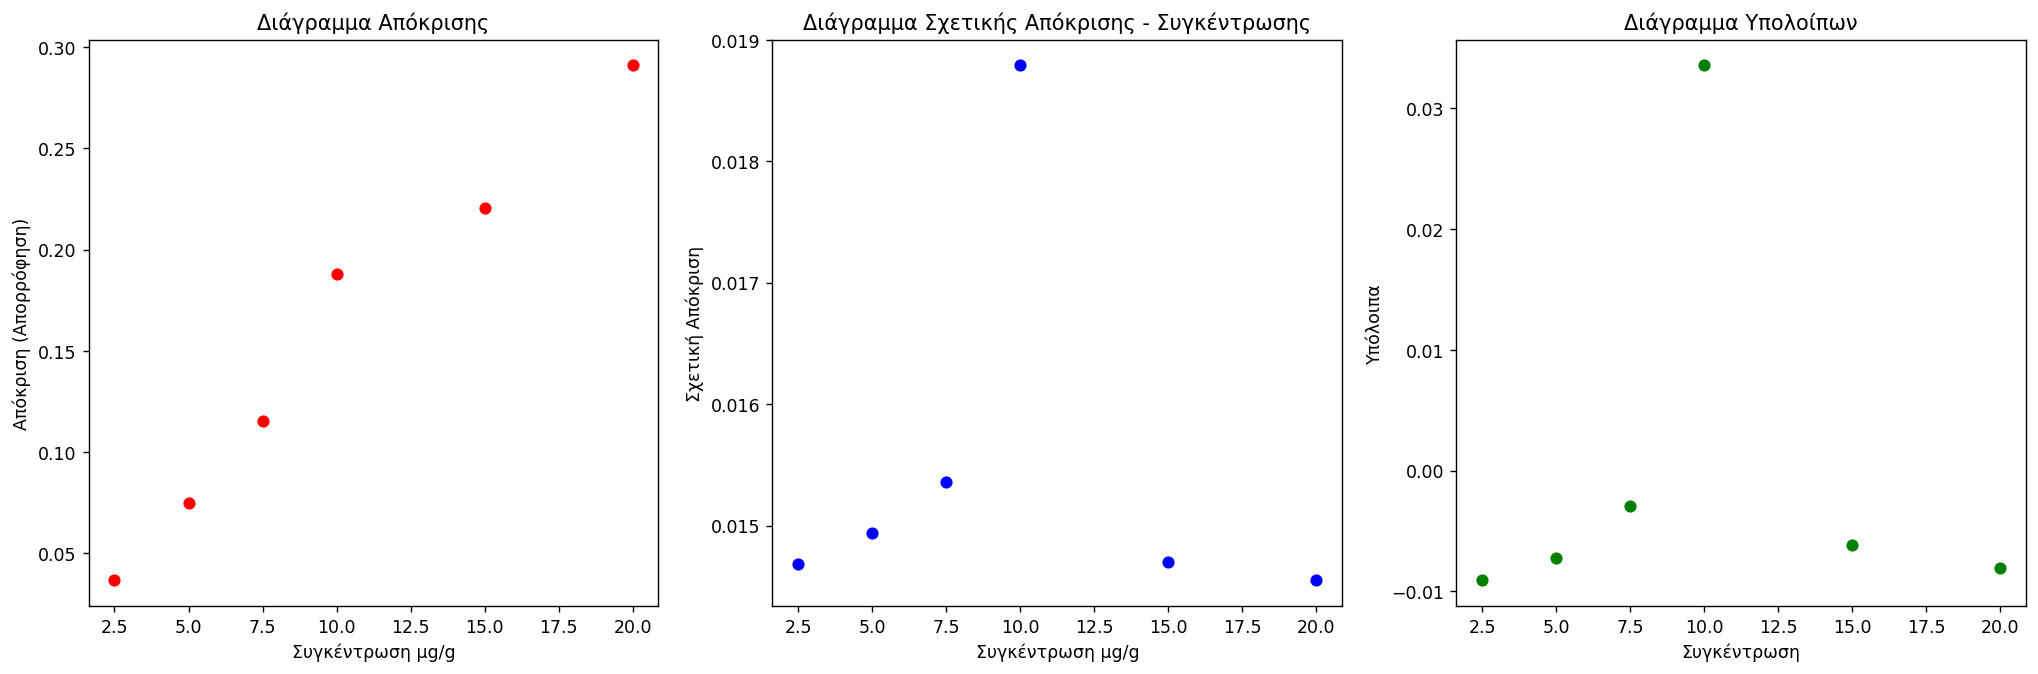

In [7]:
# Προσαρμωγή σε Μοντέλο
aux_df = pd.DataFrame({
                        'Concentration':df1[~df1["Average"].isnull()]["Concentration [Hg] (ug/g)"][1:],
                        'Signal':df1[~df1["Average"].isnull()]["Average"][1:]
                      })
model = ols('Signal ~ Concentration', data=aux_df)
results = model.fit()
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.plot(aux_df['Concentration'],aux_df['Signal'], 'ro')
ax1.set_title("Διάγραμμα Απόκρισης")
ax1.set_xlabel('Συγκέντρωση μg/g')
ax1.set_ylabel('Απόκριση (Απορρόφηση)')
ax2.plot(aux_df['Concentration'],aux_df['Signal']/aux_df['Concentration'],'bo')
ax2.set_title("Διάγραμμα Σχετικής Απόκρισης - Συγκέντρωσης")
ax2.set_xlabel('Συγκέντρωση μg/g')
ax2.set_ylabel('Σχετική Απόκριση')
ax3.plot(aux_df['Concentration'], results.resid, 'go')
ax3.set_title("Διάγραμμα Υπολοίπων")
ax3.set_xlabel("Συγκέντρωση")
ax3.set_ylabel("Υπόλοιπα")
plt.show()

In [8]:
def is_heteroscedastic(df:pd.DataFrame)->bool:
    r = df['Standard Deviation (SD)'].iloc[-1] - df['Standard Deviation (SD)'].iloc[0]
    if not (r>0.8 and r<1.2):
        return True
    else:
        return False
display.Markdown(f"**Is this heteroscedastic? \n {is_heteroscedastic(df1[~df1['Average'].isnull()])}**")

**Is this heteroscedastic ? 
 True**

### Καμπύλη Βαθμονόμησης

Υποθέτουμε γραμμική σχέση μεταξύ σήματος και συγκέντρωσης, οπότε θα εξάγουμε αυτή τη σχέση στατιστικά, με τη μέθοδο των ελαχίστων τετραγώνων. Προσαρμώζουμε τα δεδομένα σε γραμμικό μοντέλο:
$$
\begin{array}{ccc}
&&&&\\
&&&&\\
\hat{y}=\beta_1(\pm S_a)+\beta_0(\pm S_b)x&&S_{\frac yx}&&r
&&&&\\
&&&&\\
\end{array}
$$
Τα δεδομένα προσαρμώζονται στο μοντέλο, έτσι ώστε το $S_{\frac yx}$ (το τυπικό σφάλμα *των υπολοίπων*) να έχει την ελάχιστη δυνατή τιμή.

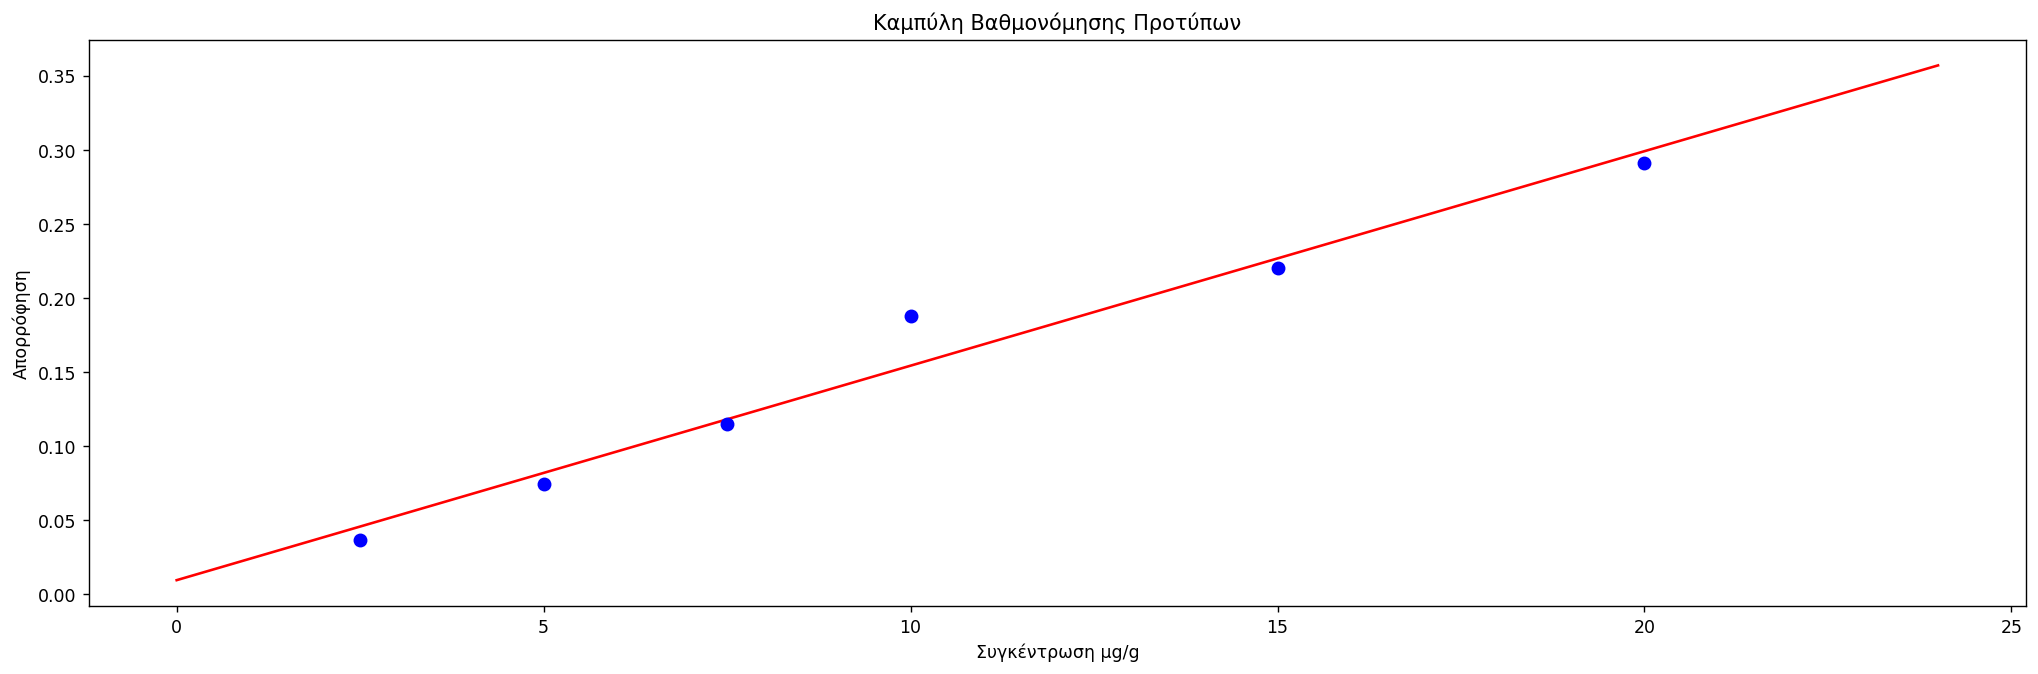

In [9]:
x = np.arange(0, 25)
plt.plot(x,results.params.Intercept+x*results.params.Concentration, 'r-')
plt.plot(aux_df['Concentration'],aux_df['Signal'], 'bo',markersize=7 )
plt.title('Καμπύλη Βαθμονόμησης Προτύπων')
plt.xlabel('Συγκέντρωση μg/g')
plt.ylabel('Απορρόφηση')
plt.show()

Είναι εμφανές οτι η τιμή για $C=10$ είναι έκτροπη (outlier) και θα πρέπει να απορριφθεί.

In [10]:
df1 = df1[df1['Concentration [Hg] (ug/g)'] != 10.0]
df1 = df1.drop(labels = ["index","Sample Number","Observation"],axis=1)
df1["Standard Deviation (SD)"] = df1["Standard Deviation (SD)"].dropna().round(5)
display.Markdown(df1.dropna().to_markdown())

|    |   Concentration [Hg] (ug/g) |   Instrument Response - Curve Height (Ai) |   Average |   Standard Deviation (SD) |   %Relative Standard Deviation (%RSD) |
|---:|----------------------------:|------------------------------------------:|----------:|--------------------------:|--------------------------------------:|
|  4 |                         0.5 |                                    0.0075 |    0.0068 |                    0.0001 |                                  1.33 |
|  7 |                         2.5 |                                    0.0373 |    0.0367 |                    0.0001 |                                  0.27 |
| 10 |                         5   |                                    0.0755 |    0.0747 |                    0.0001 |                                  0.13 |
| 13 |                         7.5 |                                    0.1157 |    0.1152 |                    0.0002 |                                  0.17 |
| 19 |                        15   |                                    0.2214 |    0.2205 |                    0.0002 |                                  0.09 |
| 22 |                        20   |                                    0.2917 |    0.291  |                    0.0002 |                                  0.07 |

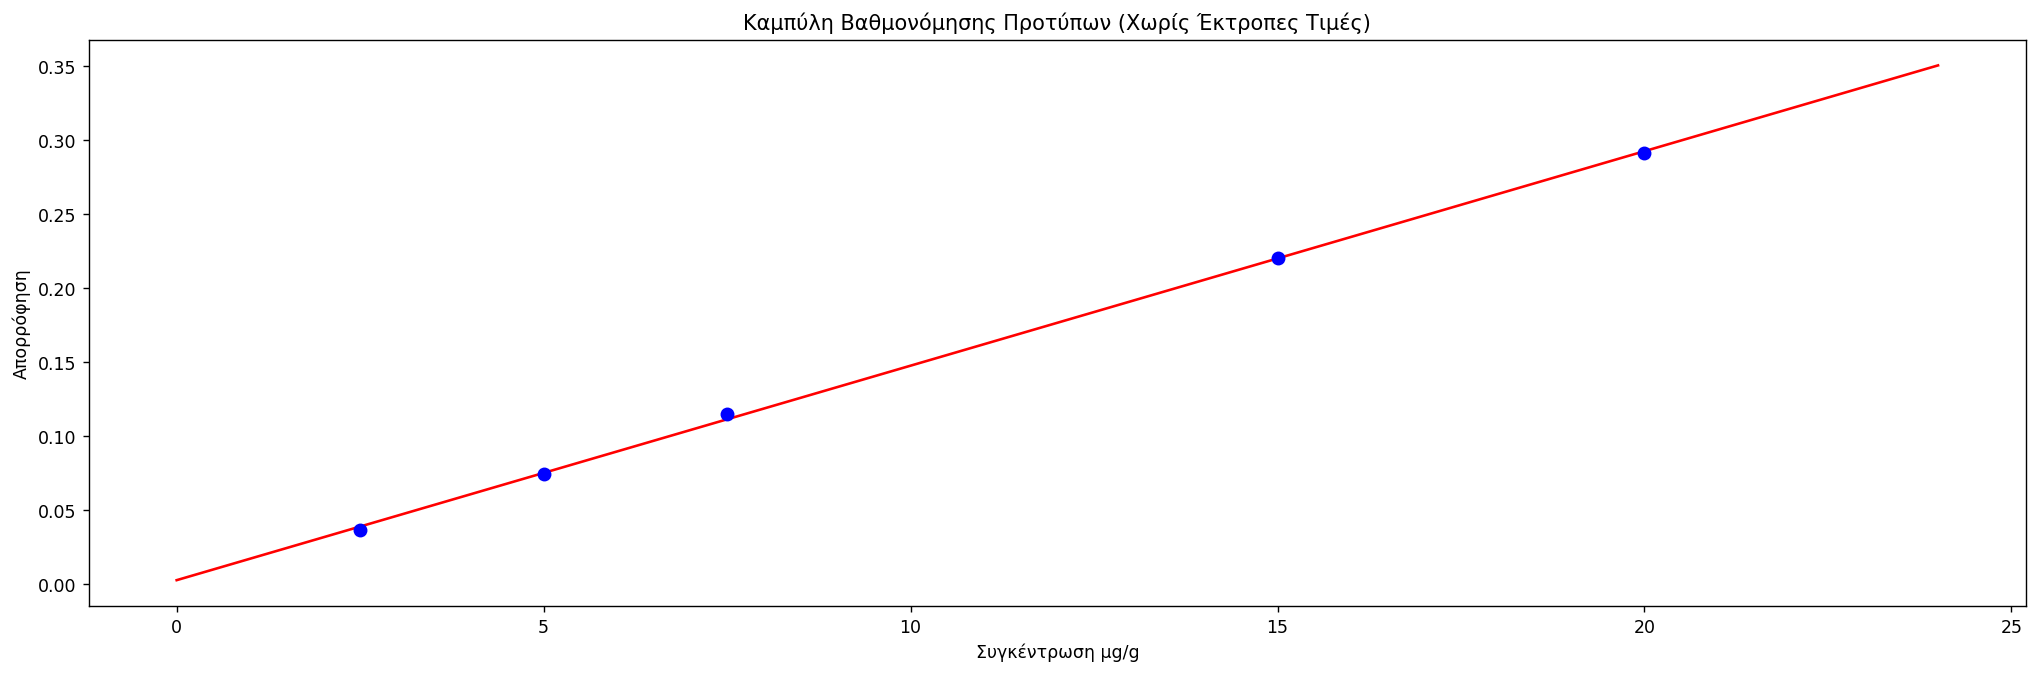

In [40]:
aux_df = pd.DataFrame({
                        'Concentration':df1[~df1["Average"].isnull()]["Concentration [Hg] (ug/g)"],
                        'Signal':df1[~df1["Average"].isnull()]["Average"][1:]
                      })
model = ols('Signal ~ Concentration', data=aux_df)
results = model.fit()
x = np.arange(0, 25)
plt.plot(x,results.params.Intercept+x*results.params.Concentration, 'r-')
plt.plot(aux_df['Concentration'],aux_df['Signal'], 'bo',markersize=7 )
plt.title('Καμπύλη Βαθμονόμησης Προτύπων (Χωρίς Έκτροπες Τιμές)')
plt.xlabel('Συγκέντρωση μg/g')
plt.ylabel('Απορρόφηση')
plt.show()
# display.Markdown(aux_df.to_markdown())

## Προσαρμωγή Σε Γραμμικό Μοντέλο

Αφού αποφανθήκαμε για την ετεροσκεδαστικότητα, θα πρέπει τώρα να προσαρμώσουμε τα καθαρισμένα δεδομένα σε γραμμικό μοντέλο και να αποφανθούμε για τα όρια ανίχνευση και ποσοτικοποίησης **του οργάνου** και για την ύπαρξη τυχόν συστηματικού σφάλματος. Όπως πάντα για χρησιμοποιήσουμε απλό γραμμικο μοντέλο με παλινδρόμηση. Η γενική εξίσωση θα είναι: 
$$
\begin{array}{ccc}
&&&&\\
&&&&\\
\hat{y}=\beta_1(\pm S_a)+\beta_0(\pm S_b)x&&S_{\frac yx}&&r
&&&&\\
&&&&\\
\end{array}
$$
Σημειώνουμε ότι μετά της απόρριψη έκτροπων τιμή, η καμπύλη θα πρέπει να έχει τουλάχιστον 6 σημεία (έχουμε ακριβώς 6).

In [45]:
# Προσαρμωγή σε Μοντέλο
aux_df = pd.DataFrame({
                        'Concentration':df1[~df1["Average"].isnull()]["Concentration [Hg] (ug/g)"],
                        'Signal':df1[~df1["Average"].isnull()]["Average"]
                      })
model = ols('Signal ~ Concentration', data = aux_df)
results = model.fit()
print(results.summary())
print(results.bse)
Syx=sqrt(results.mse_resid)
display.Markdown(f"$R^2 = {results.rsquared.round(4)*100}\%$")

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     8434.
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           8.43e-08
Time:                        16:18:13   Log-Likelihood:                 28.212
No. Observations:                   6   AIC:                            -52.42
Df Residuals:                       4   BIC:                            -52.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0016      0.002      0.901

$R^2 = 99.95\%$

||||
-----|-----|------
Όρος|Τιμή|Τυπικό Σφάλμα
Σταθερός Όρος|0.002900|0,002227
Συντελεστής Συγκέντρωσης|0.014500|0,000187
Υπόλοιπα||0.002719
Συντελεστής Συσχέτισης|0.99950|

## Στατιστικα Σημαντική Τομή
Πρέπει να εξαιτάσουμε αν η τομή, δηλαδή ο σταθερός όρος της εξίσωσης είναι στατιστικά σημαντικά διαφορετικός από το μηδέν. Αν δεν είναι τότε υπάρχει συστηματικό σταθερό σφάλμα (bias) και αν είναι μπορούμε να θεωρήσουμε τον όρο αυτό μηδέν

### α-Επιπέδου Ελεγχος Υπόθεσης για την Παράμετρο $\beta_1$

Αρχικά θα πρέπει να ορίσουμε την μηδενική και εναλλακτική υπόθεση.

|||
---|----
Μηδενική Υπόθεση|$H_0:\;\beta_1=c$
Εναλλακτική Υπόθεση|$H_1:\;\beta_1\neq c$

Όπου $c$ μπορεί να είναι οποιοσδήποτε (επιτρεπτή) τιμή για την τομή. Συνήθως ελέγχουμε αν είναι ίση με το μηδέν. Επιπλέον η εναλλακτική υπόθεση μπορεί να είναι επίσης $H_1:\;\beta_1> c$ ή $H_1:\;\beta_1< c$

Δεύτερον θα εκτελέσουμε T-Test, ενός δείγματος, χρησιμοποιόντας τον ακόλουθο τύπο:
$$
\begin{array}{c}
\\
\\
T_{exp} = \dfrac{b_1-c}{\bigg( \dfrac{\sqrt{MSE} }{\sqrt{\sum(x_i-\overline{x})^2}} \bigg)}
\\
\\
\end{array}
$$

Τρίτον, θα χρησιμοποιήσουμε την τιμή $T_{exp}$ για να υπολογίσουμε την τιμή P, η οποία δίνει τη πιθανότητα να εμφανιστεί η συγκεκριμένη τιμή $T_{exp}$, όταν ισχύει η μηδενική υπόθεση. Η τιμή $P$ αναφέρεται σε κατανομή $T$ με $n-2$ βαθμούς ελευθερίας. Τελικά παίρνουμε μια απόφαση:

* Αν η τιμή $P$ είναι μικρότερη του επιπέδου σημαντικότητας $α$, τότε απορρίπτουμε τη μηδενική υπόθεση, και διατηρούμε την εναλλακτική υπόθεση. Συμπεραίνουμε οτι "υπάρχουν επαρκής αποδήξεις, σε επίπεδο εμπιστοσύνης α, να συμπεράνουμε οτι υπάρχει γραμμική σχέση **στον πληθυσμό** μεταξύ συγκέντρωσης και σήματος"

* Αν η τιμή $P$ είναι μεταξύτερη του επιπέδου σημαντικότητας $α$, τότε δεν απορρίπτουμε την μηδενική υπόθεση αλλά την διατηρούμε, και συμπεραίνουμ οτι "δε υπάρχουν επαρκής αποδήξεις, σε επίπεδο εμπιστοσύνης α, να συμπεράνουμε οτι υπάρχει γραμμική σχέση **στον πληθυσμό** μεταξύ συγκέντρωσης και σήματος"

Βάση του άνω πίνακα αποτελεσμάτων είναι:
$T_{exp}=1.450<T_{theo}=2.776$
Επομένως κρατάμε τη μηδενική υπόθεση και η τιμή **δεν** είναι στατιστικά διαφορετική από το μηδέν.
Επειδή έχουμε πρόσβαση και στην τιμή $P$ (στήλη $P>|t|$), βρίσκουμε οτι αυτή η τιμή είναι μεγαλύτερη του $\alpha=0.005$ επομένως η τομή δεν είναι στη πραγματικότητα μηδέν.

## Όρια Ανίχνευση και Ποσοτικοποίησης

Από τα δεδομένα που έχουμε πλέον, μπορούμε να υπολογίσουμε τα όρια ανίχνευσης και ποσοτικοποίησης **του οργάνου**. Ο γενικότερος όρος *ανιχνευσημότητα* εκφράζει την ικανότητα της μεθόδου να ανιχνεύει μικρές ποσότητες του αναλύτη. Εκφράζεται ποιό συγκεκριμένα με το *όριο ανίχνευσης* και το *όριο ποσοτικοποίησης*. Το πρώτο εκφράζει την ελάχιστη συγκέντρωση του αναλύτη που μπορεί να διακριθεί αναμφίβολα από τον θόρυβο και η δεύτερη την ελάχιστη συγκέντρωση του αναλύτη που μπορεί αναμφίβολα να ποσοτικοποιηθεί παρουσία του θορύβου. Στη πράξη το δεύτερο ορίζεται συναρτίσει του πρώτου, και υπάρχουν διάφοροι ορισμοί για το όριο ανίχνευσης.
Στατιστικά, υπάρχουν δύο δυνατά σφάλματα κατά την απόφαση αν υπάρχει αναλύτης ή οχι. Μπορεί να αποφασίσουμε οτι υπάρχει ενώ δεν υπάρχει (σφάλμα πρώτου είδους **α**) ή να αποφασίσουμε οτι δεν υπάρχει ενώ υπάρχει (σφάλμα δεύτερου είδους **β**).

Ο πρώτος ορισμός του Ορίου Ανίχνευσης είναι κυρίως στατιστικός
> Όριο ανίχνευση (LOD) είναι το ελάχιστο παρατηρούμενο *σήμα* του αναλύτη, το οποίο με αξιοπιστία $(1-α)$ μπορεί να θεωρηθεί οτι είναι σήμα προκαλούμενο από τον αναλύτη. Τότε το $α$ είναι η πιθανότητα σφάλματος πρώτου είδους
 
Βάση θορύβου και των άνω μπορούμε να προχωρήσουμε σε ένα ποιό συγκεκριμένο ορισμό. Έστω οτι μετράμε λευκά δείγματα $(\overline{S_{blank}},s_r)$. Τότε θα είναι:
$$
S=\overline{S_{blank}}+ks_r
$$
Εδώ $k$ είναι μια ελεύθερη παράμετρος που δίδει την επιθυμητή τιμή $1-α$ (συνήθως $k=3.3 \iff a=0.005 \iff CI=95\%$. Τότε αν επιπλέον $w_0$ η κλίση καμπύλης απόκρισης θα είναι:
$$
LOD\equiv C = \dfrac{\overline{S_{blank}}+ks_r}{w_0}
$$
Βάση των άνω μπορούμε να αναδιατυπώσουμε τους ορισμού ως εξης:
> ***Όριο Ανίχνευσης*** είναι η συγκέντρωση του αναλύτη αυτή που δίδει αναλυτικό σήμα που διαφέρει από αυτό του θορύβου κατά 3.3 φορές τη τυπική απόκλιση του θορύβου (λευκού).
> ***Όριο Ποσοτικοποίησης*** είναι η συγκέντρωση του αναλύτη αυτή που δίδει αναλυτικό σήμα που διαφέρει από αυτό του θορύβου κατά 10 φορές τη τυπική απόκλιση του θορύβου (λευκού).

> *Παρατήρηση:* \
Σε κάποιες περιπτώσεις μπορούμε να χρησιμοποιήσουμε και το *όριο εγγυημένη καθαρότητας ΄΄οπου $k=6$*

**Γενικές Μέθοδοι Προσδιορισμού**

Μέθοδος|Παρατήρηση|Περιγραφή
-----|------|-----
Οπτική Αξιολόγηση|Για μη ενόργανες|Αναλύονται πρότυπα μειωμένης συγκέντρωσης μέχρι να διακρίνεται μόλις ο αναλύτης
Λόγος $\frac SN$|Ενόργανες με Γραμμή Θορύβου|Μετριέται ή από λευκά ή από πρότυπα εξαιρετικά χαμηλής συγκέντρωσης που αντιπροσωπεύουν τον θόρυβο. Η συγκέντρωση που δίδει λόγο σημάτων $\dfrac SN=3.3$ ή $\dfrac SN=3$ είναι το LOD και 10 για το LOD
Τυπικής Απόκλισης|Πρακτικά ο συνηθέστερος|Με γενικό τύπο $3.3\;\dfrac{s}{w_0}$ και για 10 για LOQ. Απαιτεί καμπύλη απόκρισης $(w_0)$

**Εκτιμήτριες Τυπικής Απόκλισης**

|||
-----|-----
$s_{blank}$|Από ανάλυση λευκών
$s_{low}$|Από άγνωστο χαμηλής συγκέντρωησης
Τομή SD|Από την τομή $s=f(c)$ από σειρά αγνώστων ή συνθετικών
Τυπικό Σφάλμα Κλίσης Απόκρισης|Από την καμπύλη απόκρισης, το τυπικό σφάλμα *της κλίσης*
Τυπικό Σφάλμα Υπολείπων Απόκρισης|Από την καμπύλη απόκρισης, το τυπικό σφάλμα *των υπολοίπων*
Φασματομετρικά|Από τη σχετική τυπική απόκλιση $3.3\;\dfrac{\%RSD}{100}$

Με βάση τα δεδομένα που έχουμε είδη, μπορούμε να προσδιορίσουμε τα όρια LOD και LOQ από τις τυπικές αποκλίσεις της τομής $(s_a)$ και των υπολοίπων $(s_{y/x})$ ως:
$$
\begin{array}{cc}
LOD_a = 3.3\;\dfrac{s_a}{w_0}&&LOQ_a = 10\;\dfrac{s_a}{w_0}\\
LOD_{y/x} = 3.3\;\dfrac{s_{y/x}}{w_0}&&LOQ_{y/x} = 10\;\dfrac{s_{y/x}}{w_0}
\end{array}
$$

In [47]:
# Unsafe, must double-check
detectability = pd.DataFrame(data = {
    '':['Intercept', 'Residuals'],
    'LOD (ng/mL)':[3.3*results.bse[0]/results.params[0] ,3.3*Syx/results.params[0]],
    'LOQ (ng/mL)':[10*results.bse[0]/results.params[0],10*Syx/results.params[0]]
})
detectability = detectability.round(2)
display.Markdown(detectability.to_markdown())
print(results.params)

Intercept        0.001558
Concentration    0.014565
dtype: float64


In [14]:
## Πιστότητα
### Επαναληψημότητα

# Reshape and cleanup
df2 = pd.read_csv("Άσκηση ΜΚ-04 - Επικύρωση Μεθόδου T-2. Επαναληψημότητα.csv",index_col=False)
df2.columns = ['Repeat Analysis','1','2','3','4','5','6']
df2=df2.iloc[2:]
for idx,col in df2.iterrows():
    col.astype('float64',errors='ignore')
df2
i=False
for col in df2:
    if i:
        sd = df2[col][0:6].std()
        m = df2[col][0:6].mean()
        df2[col][9] = sd
        df2[col][8] = m
        df2[col][10] = (sd/m*100)
        
    else:
        i=True
df2
aux_df2 = df2.drop(["Repeat Analysis"],axis=1)
aux_df2

,1,2,3,4,5,6
2,120.300000,245.100000,454.100000,668.700000,919.600000,1332.000000
3,121.800000,242.700000,471.000000,711.100000,946.900000,1255.000000
4,114.800000,241.300000,467.000000,753.000000,901.700000,1426.000000
5,110.100000,242.200000,496.800000,723.000000,949.200000,1355.000000
6,119.600000,241.400000,480.600000,720.700000,955.800000,1404.000000
7,108.000000,247.700000,475.600000,705.600000,996.500000,1389.000000
8,115.766667,243.400000,474.183333,713.683333,944.950000,1360.166667
9,5.744795,2.518730,14.281235,27.485808,32.588878,61.590313
10,4.962391,1.034811,3.011754,3.851261,3.448741,4.528145
11,NaN,NaN,NaN,NaN,NaN,NaN


### Έκτροπες Τιμες

Ένας περισσότερο γενικός και τυπικός στατιστικό τρόπος για να ανιχνευθούν οι έκτροπες τιμές είναι το κριτήριο Q, το οποίος όμως μπορεί να εντοπίσει μόνο μία έκτροπη (το πολύ). Διατάσσουμε το σύνολο τιμών σε αύξουσα ή φθίνουσα σειρά, οπότε έκτροπη μπορεί να είναι μόνο η πρώτη ή η τελευταία (η μέγιστη ή η ελάχιστη). Έστω *gap* η κατ' απόλυτη τιμή διαφορά έκαστης "ύποπτης τιμή" (πρώτης ή τελευταίας) με την κοντινότερη (δεύτερη ή προ-τελευταία) και έστω *range* η κατ' απόλυτη τιμή διαφορά της μέγιστης και της ελάχιστης (συμπεριλαμβανομένων των ύποπτων άκρων, δηλαδή η διαφορά των δύο ύποπτων).Τότε:
$$
Q = \dfrac{|gap|}{range=min-max}\\
Q>Q_{theo}^{CI}\;\;\;\iff\;\;\; \text{Η ύποπτη τιμή είναι έκτροπη}
$$
$Q_{theo}$ είναι ένα θεωρητικό κατόφλι που προκύπτει από τη στάθμη εμπιστοσύνης και το πλήθος των τιμών:

|Πλήθος Τιμών|3|4|5|6|7|8|9|10
-----|------|-----|----|----|---|----|----|----
$Q_{90\%}$|0.941|0.765|0.642|0.560|0.507|0.468|0.437|0.412
$Q_{95\%}$|0.970|0.829|0.710|0.625|0.568|0.526|0.493|0.466
$Q_{99\%}$|0.994|0.926|0.821|0.740|0.680|0.634|0.598|0.568

In [15]:
# def Q_test(series:pd.Series,ci=95)->tuple[bool, float]:
def Q_test(ser, ci =95):
    "Handle variable titles. This needs to be a class. Type check errors"
    Qtable = pd.DataFrame(data = {
        'Number of values': ['3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'],
        '90%':[0.941,0.765,0.642,0.560,0.507,0.468,0.437,0.412,0.3312,0.3170,0.3045,0.2938,0.2848,0.2765,0.2691,0.2626,0.2564,0.2511],
        '95%':[0.970,0.829,0.710,0.625,0.568,0.526,0.493,0.466,0.3922,0.3755,0.3615,0.3496,0.3389,0.3293,0.3208,0.3135,0.3068,0.3005],
        '99%':[0.994,0.926,0.821,0.740,0.680,0.634,0.598,0.568,0.5028,0.4831,0.4664,0.4517,0.4385,0.4268,0.4166,0.4081,0.4002,0.3922],
    })
    if ci not in (90,95,99):
        raise ValueError('Confidence interval must be 90,95,99 as an integer')
    Qtheo = Qtable[Qtable['Number of values'] == str(len(ser))][str(ci)+'%'].iloc[0]
    ser = ser.sort_values()
    rang = abs(ser.iloc[len(ser)-1]-ser.iloc[0])
    gap_min = abs(ser.iloc[1]-ser.iloc[0])
    gap_max = abs(ser.iloc[len(ser)-1]-ser.iloc[len(ser)-2])
    if gap_min/rang>Qtheo:
        return (True, ser.iloc[0])
    elif gap_max>Qtheo:
        return (True, ser.iloc[len(ser)-1])
    else:
        return (False,None)

In [16]:
# Add relevant spaces
aux_df2 = df2.drop("Repeat Analysis",axis=1)
# Detect outliers with Dixon's Q test
for col in aux_df2:
    x= Q_test(aux_df2[col][0:6],ci=95)
    if x[0]:
        series_excised_outlier = df2[col][df2[col]!=x[1]][:5]
        m = series_excised_outlier.mean()
        sd = series_excised_outlier.std()
        rsd = sd/m*100
        df2[col][11] = m
        df2[col][12] = sd
        df2[col][13] = rsd

del aux_df2
df2

,Repeat Analysis,1,2,3,4,5,6
2,1,120.300000,245.100000,454.100000,668.700000,919.600000,1332.000000
3,2,121.800000,242.700000,471.000000,711.100000,946.900000,1255.000000
4,3,114.800000,241.300000,467.000000,753.000000,901.700000,1426.000000
5,4,110.100000,242.200000,496.800000,723.000000,949.200000,1355.000000
6,5,119.600000,241.400000,480.600000,720.700000,955.800000,1404.000000
7,6,108.000000,247.700000,475.600000,705.600000,996.500000,1389.000000
8,Average,115.766667,243.400000,474.183333,713.683333,944.950000,1360.166667
9,Standard Deviation (SD),5.744795,2.518730,14.281235,27.485808,32.588878,61.590313
10,Relative Standard Deviation (%RSD),4.962391,1.034811,3.011754,3.851261,3.448741,4.528145
11,Average - No Outliers,114.560000,242.540000,469.660000,705.820000,934.640000,1347.000000


In [17]:
# Από τα νούμερα και μόνο είναι εμφανές οτι έχουμε ετεροσκεδαστικότητα, όπου η τυπική απόκλιση αυξάνει με τη συγκέντρωση και σχετική τυπική απόκλιση είναι περίππου σταθερή
def heteroscedastic(x:pd.DataFrame)->bool:
    thresh = x.loc[7,'6'] - x.loc[7,'1']
    if  thresh<0.8 or thresh>1.2:
        return True
    else:
        return False
heteroscedastic(df2)


True

In [18]:
display.Markdown(f"$\%RSD_r:{round(df2.iloc[11][1:6].mean(),2)}\%$")

$\%RSD_r:2.63\%$

In [19]:
## Ενδιάμεση Πιστότητα

df3 = pd.read_csv("Άσκηση ΜΚ-04 - Επικύρωση Μεθόδου T-3 Ενδιάμεση Πιστότητα.csv",header=1)
df3["Analyst"] = df3["Analyst"].astype('Int64',copy=False)
display.Markdown(df3.to_markdown())

|    | Repeat                              | Analyst   |   Sample_1 |   Sample_2 |
|---:|:------------------------------------|:----------|-----------:|-----------:|
|  0 | 1                                   | 1         |      495.6 |     1013.5 |
|  1 | 2                                   | 1         |      512   |     1015.6 |
|  2 | 3                                   | 1         |      511.6 |     1008.9 |
|  3 | 4                                   | 1         |      527.2 |     1019.9 |
|  4 | 5                                   | 1         |      509.3 |     1014.6 |
|  5 | 6                                   | 1         |      523.7 |     1020.2 |
|  6 | 1                                   | 2         |      500.9 |      997.5 |
|  7 | 2                                   | 2         |      502.9 |     1027.8 |
|  8 | 3                                   | 2         |      507.4 |      987.8 |
|  9 | 4                                   | 2         |      513   |      886.1 |
| 10 | 5                                   | 2         |      501.9 |      967.2 |
| 11 | 6                                   | 2         |      509.6 |     1008.3 |
| 12 | 1                                   | 3         |      478.3 |      994.4 |
| 13 | 2                                   | 3         |      514.8 |     1012.2 |
| 14 | 3                                   | 3         |      511   |     1027.2 |
| 15 | 4                                   | 3         |      508.3 |     1022.5 |
| 16 | 5                                   | 3         |      517.1 |     1022   |
| 17 | 6                                   | 3         |      522.7 |     1028.1 |
| 18 | Grand Average                       | <NA>      |      nan   |      nan   |
| 19 | Standard Deviation (SDR)            | <NA>      |      nan   |      nan   |
| 20 | Relative Standard Deviation (%RSDR) | <NA>      |      nan   |      nan   |

In [20]:
# Grand average
i = 0
for idx in df3:
    if i>1:
        r = Q_test(df3[idx][:18])
        if r[0]:
            print(r[1])
            ser = df3[df3[idx] != r[1]][idx][:17]
        else:
            ser = df3[idx][:18]
        av = ser.mean()
        sd = ser.std()
        df3[idx][18] = av
        df3[idx][19] = sd
        df3[idx][20] = sd/av*100
    else:
        i +=1

# Υπάρχουν έκτροπες τιμές και στις δύο ομάδες. Απορρίπτονται πριν τους υπολογισμούς
Q_test(df3["Sample_1"][:18])

478.3
886.1


(True, 478.3)

In [21]:
display.Markdown(df3.to_markdown())

|    | Repeat                              | Analyst   |   Sample_1 |   Sample_2 |
|---:|:------------------------------------|:----------|-----------:|-----------:|
|  0 | 1                                   | 1         |  495.6     | 1013.5     |
|  1 | 2                                   | 1         |  512       | 1015.6     |
|  2 | 3                                   | 1         |  511.6     | 1008.9     |
|  3 | 4                                   | 1         |  527.2     | 1019.9     |
|  4 | 5                                   | 1         |  509.3     | 1014.6     |
|  5 | 6                                   | 1         |  523.7     | 1020.2     |
|  6 | 1                                   | 2         |  500.9     |  997.5     |
|  7 | 2                                   | 2         |  502.9     | 1027.8     |
|  8 | 3                                   | 2         |  507.4     |  987.8     |
|  9 | 4                                   | 2         |  513       |  886.1     |
| 10 | 5                                   | 2         |  501.9     |  967.2     |
| 11 | 6                                   | 2         |  509.6     | 1008.3     |
| 12 | 1                                   | 3         |  478.3     |  994.4     |
| 13 | 2                                   | 3         |  514.8     | 1012.2     |
| 14 | 3                                   | 3         |  511       | 1027.2     |
| 15 | 4                                   | 3         |  508.3     | 1022.5     |
| 16 | 5                                   | 3         |  517.1     | 1022       |
| 17 | 6                                   | 3         |  522.7     | 1028.1     |
| 18 | Grand Average                       | <NA>      |  511.118   | 1011.04    |
| 19 | Standard Deviation (SDR)            | <NA>      |    8.40418 |   16.2445  |
| 20 | Relative Standard Deviation (%RSDR) | <NA>      |    1.64428 |    1.60671 |

### One Way ANOVA
Μπορούμε να εκτελέσουμε μονόδρομη ANOVA σε κάθε δείγμα, συσχετίζοντας τον αναλυτή με τα αποτελέσματα. Τότε εξαιτάζουμε αν υπάρχει σημαντική διαφορά στη διακύμανση **μεταξύ** των ομάδων (αναλυτών) συγκριτικά με τη διακύμαση **εντός** των ομάδων. Αν δεν υπάρχει σημαντική διαφορά, τότε μπορούμε να υποθέσουμε οτι ο αναλύτης δεν παίζει σημαντικό ρόλο στο αποτέλεσμα (ορθότερα ότι όλες οι τιμές προέρχονται από έναν κοινό πληθυσμό).

In [22]:
aux_df3 = df3.drop(labels="Repeat",axis=1)
s1,s2 = aux_df3.drop(labels="Sample_2",axis=1)[0:18],aux_df3.drop(labels="Sample_1",axis=1)[:18]
if Q_test(s1["Sample_1"])[0]:
    s1 = s1[s1["Sample_1"] != Q_test(s1["Sample_1"])[1]]
if Q_test(s2["Sample_2"])[0]:
    s2 = s2[s2["Sample_2"] != Q_test(s2["Sample_2"])[1]]
aov1=pg.anova(data=s1,dv="Sample_1",between="Analyst",detailed=True)
aov2=pg.anova(data=s2,dv="Sample_2",between="Analyst",detailed=True)
aov1["Standard Deviation"] = [sqrt(aov1["SS"][0]),None]
aov1["%Relative Standard Deviation"] = [sqrt(aov1["SS"][0])/s1["Sample_1"].mean()*100,None]
aov2["Standard Deviation"] = [sqrt(aov2["SS"][0]),None]
aov2["%Relative Standard Deviation"] = [sqrt(aov2["SS"][0])/s2["Sample_2"].mean()*100,None]
display.Markdown(aov1.to_markdown())

|    | Source   |      SS |   DF |       MS |         F |      p-unc |        np2 |   Standard Deviation |   %Relative Standard Deviation |
|---:|:---------|--------:|-----:|---------:|----------:|-----------:|-----------:|---------------------:|-------------------------------:|
|  0 | Analyst  | 254.148 |    2 | 127.074  |   2.03101 |   0.168086 |   0.224893 |               15.942 |                        3.11905 |
|  1 | Within   | 875.936 |   14 |  62.5669 | nan       | nan        | nan        |              nan     |                      nan       |

In [23]:
display.Markdown(aov2.to_markdown())

|    | Source   |      SS |   DF |      MS |         F |       p-unc |        np2 |   Standard Deviation |   %Relative Standard Deviation |
|---:|:---------|--------:|-----:|--------:|----------:|------------:|-----------:|---------------------:|-------------------------------:|
|  0 | Analyst  | 1272.6  |    2 | 636.302 |   3.02019 |   0.0811995 |   0.301411 |              35.6736 |                         3.5284 |
|  1 | Within   | 2949.56 |   14 | 210.683 | nan       | nan         | nan        |             nan      |                       nan      |

Δηλαδή:

In [24]:
display.Markdown(f"$\%RSD_R:{aov1['%Relative Standard Deviation'][0].round(2)}\%$\n Πρώτο Δείγμα")

$\%RSD_R:3.12\%$
 Πρώτο Δείγμα

In [25]:
display.Markdown(f"$\%RSD_R:{aov2['%Relative Standard Deviation'][0].round(2)}\%$\n Δεύτερο Δείγμα")

$\%RSD_R:3.53\%$
 Δεύτερο Δείγμα

In [26]:
rsd_av =((aov1['%Relative Standard Deviation'][0].round(2)+aov2['%Relative Standard Deviation'][0].round(2))/2).round(2)
display.Markdown(f"$\%RSD_R:{round(rsd_av,2)}\%$\n Μέση Τιμή")

$\%RSD_R:3.32\%$
 Μέση Τιμή

### Howitz και $HORRAT_R$

Η εμπειρική σχέση Horwitz δίνει την "αναμενόμενη" σχετική τυπική απόκλιση για τη δωσμένη συγκέντρωση. Επομένως, ο λόγος της $RSD_R$ της μεθόδου με την "τιμή αναφοράς" της εξίσωσης (**HORRAT**) δίνει πληροφορίες για την ποιότητα της σχετικής τυπική απόκλισης. Γενικά λόγος πάνω από δύο είναι μη αποδεκτός ενώ λόγο 0.5 ή κάτω δείχνει εξαιρετικά αποτελέσματα. Αυτός ο λόγος αναφέρεται σε *πιστότητα* μεθόδου.

Η εξίσωση Horwitz έχει ως εξής:
$$
\%RSD_R\equiv \%CV_R = 2^{1-0.5\log{C}}
$$
Εδώ το $C$ είναι τάξη μεγέθους της συγκέντρωσης, δηλαδή ως δύναμη του 10.

In [27]:
x= 2**(1-(0.5*-9))
display.Markdown(f"$\%RSD_R\;=\;{round(x,2)}$")

$\%RSD_R\;=\;45.25$

In [28]:
display.Markdown(f"$HorRat_R={round(rsd_av/x,2)}$")

$HorRat_R=0.07$

Η τιμή αυτή δηλώνει εξαιρετική πιστότητα της μεθόδου

## Ακρίβεια
Η ακρίβεια και η ορθότητα γενικά προϋποθέτουν μια τιμή αναφοράς, συνήθως αυτή πιστοποιημένου υλικού αναφοράς, ή μπορούν να προκύψουν και από πειράματα ανάκτησης.
### Πιστοποιημένο Υλικό Αναφοράς


In [29]:
df4 = pd.read_csv("Άσκηση ΜΚ-04 - Επικύρωση Μεθόδου T-4 Ανάλυση Υλικού Αναφοράς.csv", header=0,index_col=False)
ref_val = 196
crit_p = 0.05
ser = df4["Result (ng/g)"][0:6]
print(Q_test(ser)[1])
if Q_test(ser)[0]:
    ser = df4[df4["Result (ng/g)"] != Q_test(ser)[1]].dropna()["Result (ng/g)"]
df4["Result (ng/g)"][6] = ser.mean()
df4["Result (ng/g)"][7] = ser.std()
df4["Result (ng/g)"][8] = ser.std()/ser.mean()*100
p_val=stats.ttest_1samp(ser, ref_val)[1]
if p_val<crit_p:
    print(f"Two tailed T-Test shows significant differences i.e, P-Value is {p_val}")
else:
    print(f"Two tailed T-Test shows no significant differences i.e. P-Values is {p_val}")
    
display.Markdown(df4.to_markdown())

222.0
Two tailed T-Test shows no significant differences i.e. P-Values is 0.5350059712725106


|    | A/A                |   Result (ng/g) |
|---:|:-------------------|----------------:|
|  0 | 1                  |        218      |
|  1 | 2                  |        119      |
|  2 | 3                  |        144      |
|  3 | 4                  |        217      |
|  4 | 5                  |        211      |
|  5 | 6                  |        222      |
|  6 | Average            |        181.8    |
|  7 | Standard Deviation |         46.837  |
|  8 | %RSD               |         25.7629 |

### Πειράματα Ανάκτησης

Ένας ευκολότερος τρόπος υπολογισμού της πιστότητας είναι μέσω πειραμάτων ανάκτησης. Εμβολιάζουμε δείγματα με γνωστή ποσότητα υλικού αναφοράς και μετά την διαδικασία μετράμε την ανάκτηση. Υπάρχουν δύο τύποι, ένας περισσότερος και ένας λιγότερος αυστηρός. Στη πράξη χρησιμοποιούμε την λιγότερο αυστηρή ανάκτηση, η οποία έχει ως εξής:
$$
\%R\;=\;\dfrac{C_{ini}}{C_{fin}+\Delta C}\;*100\%
$$

In [30]:
df5 =pd.read_csv("Άσκηση ΜΚ-04 - Επικύρωση Μεθόδου T-5 Πειράματα Ανάκτησης.csv",header=1, index_col=False)

def recovery(c_ini,c_fin):
    delta = c_fin-c_ini
    return c_ini/((c_fin)+delta) * 100
for idx,col in df5.iterrows():
    df5["%Recovery"][idx] = recovery(df5["Amount Added (ng/g)"][idx],df5["Amount Recovered (ng/g)"][idx])

for idx,col in df5.iterrows():
    if idx%6==0:
        df5["Average Standard Deviation (+-SD)"][idx+3] = df5["%Recovery"][idx:idx+6].std()
    
display.Markdown(df5.dropna().to_markdown())

|    |   Level Index |   Amount Added (ng/g) |   Amount Recovered (ng/g) |   %Recovery |   Average Standard Deviation (+-SD) |
|---:|--------------:|----------------------:|--------------------------:|------------:|------------------------------------:|
|  3 |             1 |                    50 |                      62   |     67.5676 |                            2.46345  |
|  9 |             2 |                   125 |                     128.4 |     94.8407 |                            0.422553 |
| 15 |             3 |                   250 |                     250.3 |     99.7606 |                            1.78036  |
| 21 |             4 |                   375 |                     370.9 |    102.236  |                            1.3744   |
| 27 |             5 |                   500 |                     489.2 |    104.515  |                            1.62101  |
| 33 |             6 |                   750 |                     718   |    109.329  |                            3.75335  |

In [31]:
display.Markdown(f"Μέση Ανάκτηση: {round(df5.dropna()['%Recovery'].mean(),2)}\%")

Μέση Ανάκτηση: 96.37\%

In [32]:
display.Markdown(f"Είναι η ανάκτηση, στατιστικός σημαντικά διαφορετική από την τιμή-στόχο 100%?")
print(stats.ttest_1samp(df5.dropna()['%Recovery'],100.0)[1]<0.05)
display.Markdown("**Επομένος η μέση ανάκτηση είναι πράγματι 100% και δεν υπάρχει σφάλμα ή ανάγκη για διόρθωση.**")

False


**Επομένος η μέση ανάκτηση είναι πράγματι 100% και δεν υπάρχει σφάλμα ή ανάγκη για διόρθωση.**

## Ανιχνευσημότητα: Όριο Ανίχνευσης και Όριο Ποσοτικοποίησης

Για να υπολογίσουμε τα Όριο Ανίχνευσης και ποσοτικοποίησης θα αναλύσουμε δείγμα που στερείται αναλύτη πολλές φορές ($Ν=10$) με τη πλήρη μέθοδο. Από τη τυπική απόκλιση αυτών μπορεί να προκύψει το LOD.

In [33]:
df6 = pd.read_csv("Άσκηση ΜΚ-04 - Επικύρωση Μεθόδου T-6 Όριο Ανίχνευσης.csv", header=0,index_col=False)
df6.loc[10,"Concentration (ng/g)"] = df6["Concentration (ng/g)"][0:10].mean()
df6.loc[11,"Concentration (ng/g)"] = df6["Concentration (ng/g)"][0:10].std()
df6.loc[12,"Concentration (ng/g)"] = 3.3*df6["Concentration (ng/g)"][0:10].std()
df6.loc[13,"Concentration (ng/g)"] = 10*df6["Concentration (ng/g)"][0:10].std()
df6["Concentration (ng/g)"] = df6["Concentration (ng/g)"].round(2)
display.Markdown(df6.to_markdown())

|    | A/A                |   Concentration (ng/g) |
|---:|:-------------------|-----------------------:|
|  0 | 1                  |                   2.48 |
|  1 | 2                  |                   1.58 |
|  2 | 3                  |                   1.48 |
|  3 | 4                  |                   2.08 |
|  4 | 5                  |                   1.33 |
|  5 | 6                  |                   1.92 |
|  6 | 7                  |                   1.42 |
|  7 | 8                  |                   1.71 |
|  8 | 9                  |                   2.17 |
|  9 | 10                 |                   1.32 |
| 10 | Average (ng/g)     |                   1.75 |
| 11 | Standard Deviation |                   0.4  |
| 12 | LOD                |                   1.31 |
| 13 | LOQ                |                   3.97 |

## Αξιολόγηση Αποτελεσμάτων και Δήλωση Καταλληλότητας

Με όλα τα αποτελέσματα επικύρωσης της μεθόδου θα κατασκευάσουμε «Συνοπτικό Πίνακα Αποτελεσμάτων» με στήλες: Παράμετρος, Προδιαγραφή, Αποτέλεσμα Επικύρωσης, Συμμόρωση / Παρατήρηση. Χρησιμοποιείστε τις προδιαγραφές από τις Κοινοτικές Οδηγίες  για τον Υδράργυρο.


In [54]:
results_df = pd.DataFrame(
    columns= [
    "Παράμετρος","Προδιαγραφή","Αποτέλεσμα Επικύρωσης","Συμμόρωση / Παρατήρηση"
    ],
    data = [["LOD - Οργάνου (ng/mL)",None,None,None], ["LOQ - Οργάνου (ng/mL)",None,None,None], ["Γραμμικότητα - Συντελεστής Συσχέτησης",None,None,None],
           ["Επαναληψημότητα %RSDr",None,None,None],["Ενδιάμεση Πιστότητα %RSDR",None,None,None], ["Ακρίβεια - Πιστοποιημένο Υλικό Αναφοράς",None,None,None],
           ["Ακρίβεια - Πειράματα Ανάκτησης",None,None,None], ["Όριο Ανίχνευσης (LOD) - Μεθόδου",None,None,None], ["Όριο Ποσοτικοποίησης (LOD) - Μεθόδου",None,None,None],
           ["Πιστότητα - Δείκτης HORRAT",None,None,None]
           ]                            
            )
results_df["Προδιαγραφή"] = [None,None,None,None,None,None,None,"<0.05 mg/Kg","<0.1 mg/Kg","<2"]

results_df["Αποτέλεσμα Επικύρωσης"] = ["3.12",'9.45','99.95%',"2.63\%","4.36%","100\%","N/A","0,00009 mg/Kg","0,00027 mg/Kg","0.07"]
ans = ["**OK**" for x in range(0,10)]
results_df["Συμμόρωση / Παρατήρηση"] = ans
display.Markdown(results_df.to_markdown())

|    | Παράμετρος                              | Προδιαγραφή   | Αποτέλεσμα Επικύρωσης   | Συμμόρωση / Παρατήρηση   |
|---:|:----------------------------------------|:--------------|:------------------------|:-------------------------|
|  0 | LOD - Οργάνου (ng/mL)                   |               | 3.12                    | **OK**                   |
|  1 | LOQ - Οργάνου (ng/mL)                   |               | 9.45                    | **OK**                   |
|  2 | Γραμμικότητα - Συντελεστής Συσχέτησης   |               | 99.95%                  | **OK**                   |
|  3 | Επαναληψημότητα %RSDr                   |               | 2.63\%                  | **OK**                   |
|  4 | Ενδιάμεση Πιστότητα %RSDR               |               | 4.36%                   | **OK**                   |
|  5 | Ακρίβεια - Πιστοποιημένο Υλικό Αναφοράς |               | 100\%                   | **OK**                   |
|  6 | Ακρίβεια - Πειράματα Ανάκτησης          |               | N/A                     | **OK**                   |
|  7 | Όριο Ανίχνευσης (LOD) - Μεθόδου         | <0.05 mg/Kg   | 0,00009 mg/Kg           | **OK**                   |
|  8 | Όριο Ποσοτικοποίησης (LOD) - Μεθόδου    | <0.1 mg/Kg    | 0,00027 mg/Kg           | **OK**                   |
|  9 | Πιστότητα - Δείκτης HORRAT              | <2            | 0.07                    | **OK**                   |